# <center> Практические задания по цифровой обработке сигналов </center>
# <center> Четвертая лабораторная работа </center>
# <center> Акустические признаки </center>

In [1]:
import librosa
import numpy as np
import scipy 
import scipy.fft
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import librosa.filters
import hashlib
from glob import glob
import os
import sklearn

%matplotlib inline

In [2]:
def draw_waveform(wav, sr, figsize=(14, 5)):
    plt.figure(figsize=figsize)
    librosa.display.waveplot(wav, sr=sr)
    plt.show()

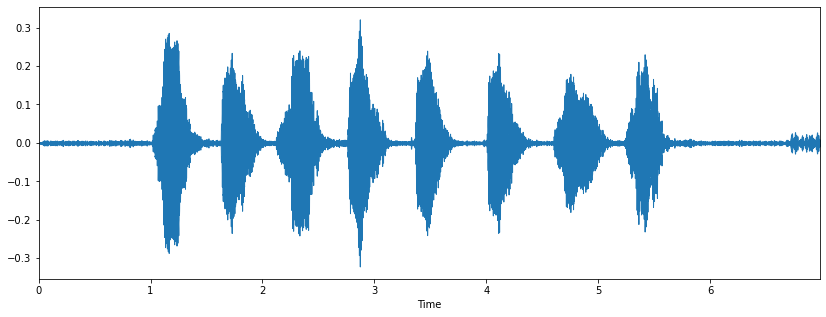

In [3]:
wav, sr = librosa.load("resources/waves_yesno/0_1_0_1_1_1_0_0.wav")
draw_waveform(wav, sr)
ipd.Audio(wav, rate=sr)

Как можно услышать, в этом датасете произносятся какие-то два слова (yes/no на иврите). Каждый файл состоит из 8 произнесений. Метки слов указаны в названиях файлов.

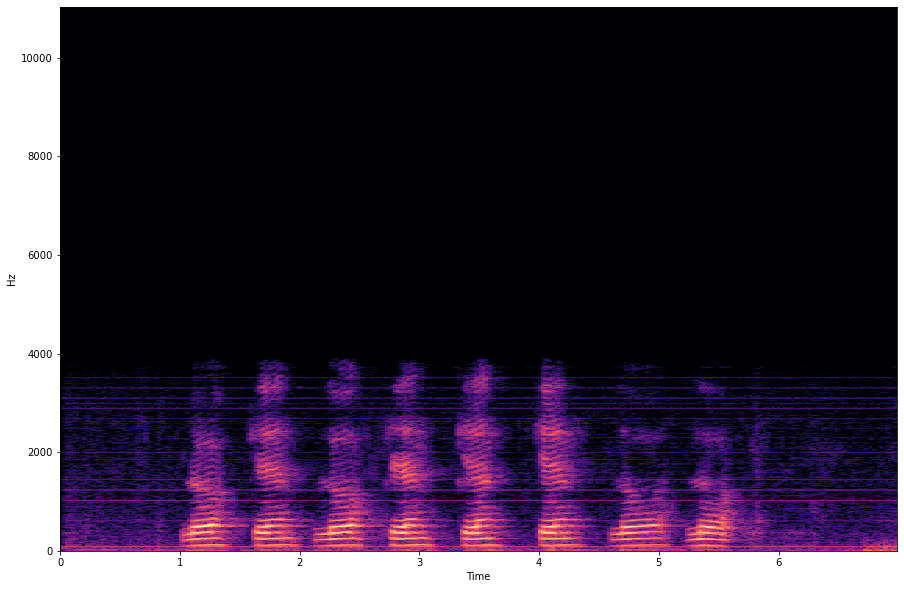

In [4]:
stft = librosa.stft(wav)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(15,10))
librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='hz');

# Задание 0.1: Анализ спектрограммы (0.5 балла)
1. Посмотрите на спектрограмму и попробуйте найти признаки, по которым можно отличить произнесение "yes" от "no". 
1. В каких частотах находится основная энергия этого речевого сигнала? 

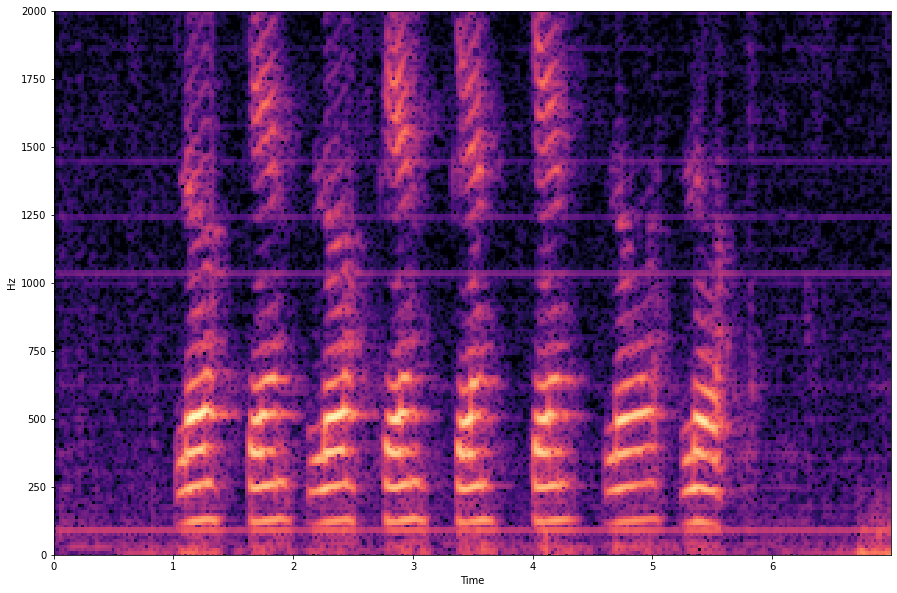

In [5]:
stft = librosa.stft(wav)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(15,10))
librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='hz');
plt.ylim(0, 2000);

1. - Слова можно например разделить по энергии на частотах с 1000-1250. При слове КЕН (yes) присутствует малая энергия по сравнению с ЛЁ (no).
2. - В основном энергия сконцентрированал с областях от 50 - 750 Гц.

# Задание 1: Мел-шкала (1 балл)
Нарисовать спектрограму в [mel-шкале](https://en.wikipedia.org/wiki/Mel_scale). 
Использовать формулу, представленную Дугласом О'Шонесси.

In [6]:
def mel(f):
    return 2595. * np.log10(1. + f / 700.)

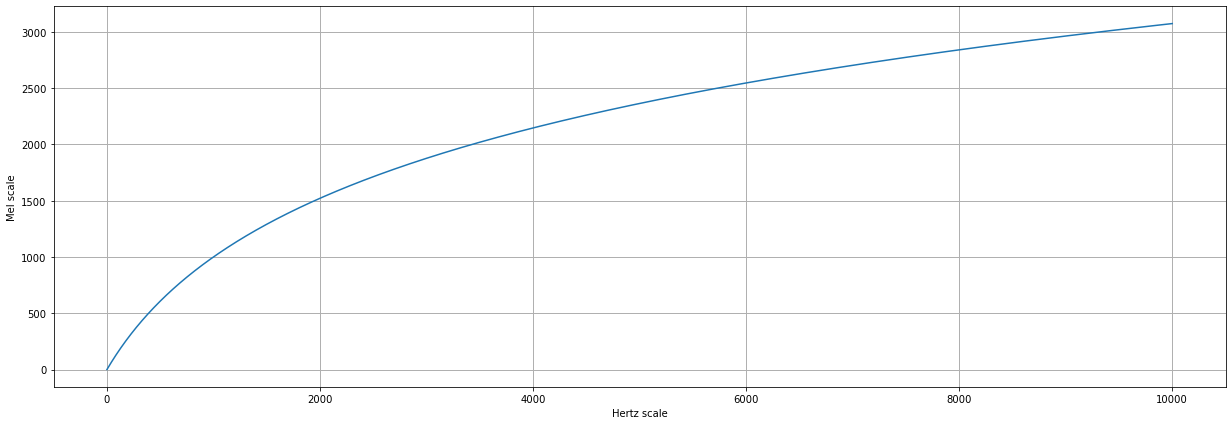

In [7]:
x = np.linspace(0, 10000, 10000)
y = mel(x)

plt.figure(figsize=(21, 7))
plt.plot(x, y)
plt.xlabel('Hertz scale')
plt.ylabel('Mel scale')
plt.grid(linestyle='-', linewidth=1)
plt.show()

In [8]:
def test_mel():
    x = np.random.randint(100, size=(1000, 100))
    x_mel = mel(x)
    x_hz = 700.0 * (10.0 ** (x_mel / 2595.0) - 1.0)
    assert np.allclose(x, x_hz), "TEST Hertz -> Mel -> Hertz  failed. "
    print("Ok!")
test_mel() 

Ok!


# Мел-фильтры
Одними из наиболее популярных акустических признаков являются Filter Banks (fbanks). 
fbanks вычисляются применением нескольких (количество фильтров = количество fbanks) треугольных фильтров к мел-спектрограмме. Чтобы не делать два действия со спектрограммой, переход к мел-шкале и применение фильтров в мел-шкале можно заменить на перевод мел-фильтров в Герц-шкалу и применение их к Герц-спектрограмме.



# Задание 2 (3 балла)
Реализуйте функцию вычисления fbank. 

In [9]:
def hz2mel(hz):
    return 2595 * np.log10(1 + hz / 700.)

def mel2hz(mel):
    return 700 * (10 ** (mel /  2595.0) - 1)

In [10]:
def mel_filters(sr, n_fft, n_mels=40):    
    
    f_max = int(sr / 2)
    hz = np.linspace(0, f_max, n_fft // 2 + 1, endpoint=True)
    mels = np.linspace(0, hz2mel(f_max), n_mels + 2)
    mel_f = mel2hz(mels)
    
    fdiff = np.diff(mel_f)
    ramps = np.subtract.outer(mel_f, hz)

    fbank = np.zeros((n_mels, n_fft // 2 + 1))
    for i in range(n_mels):
        lower = -ramps[i] / fdiff[i]
        upper = ramps[i + 2] / fdiff[i + 1]
        fbank[i] = np.maximum(0, np.minimum(lower, upper))

    enorm = 2.0 / (mel_f[2 : n_mels + 2] - mel_f[:n_mels])
    fbank *= enorm[:, np.newaxis]

    return fbank

In [11]:
assert mel_filters(32, 46, 4).shape == (4, 24) and \
    mel_filters(65, 45, 5).shape == (5, 23), "Wrong shape"
assert np.allclose(mel_filters(16, 8, 4), librosa.filters.mel(16, 8, n_mels=4, htk=True))
assert np.allclose(mel_filters(8600, 512, 40), librosa.filters.mel(8600, 512, n_mels=40, htk=True))
print("All ok!")

All ok!


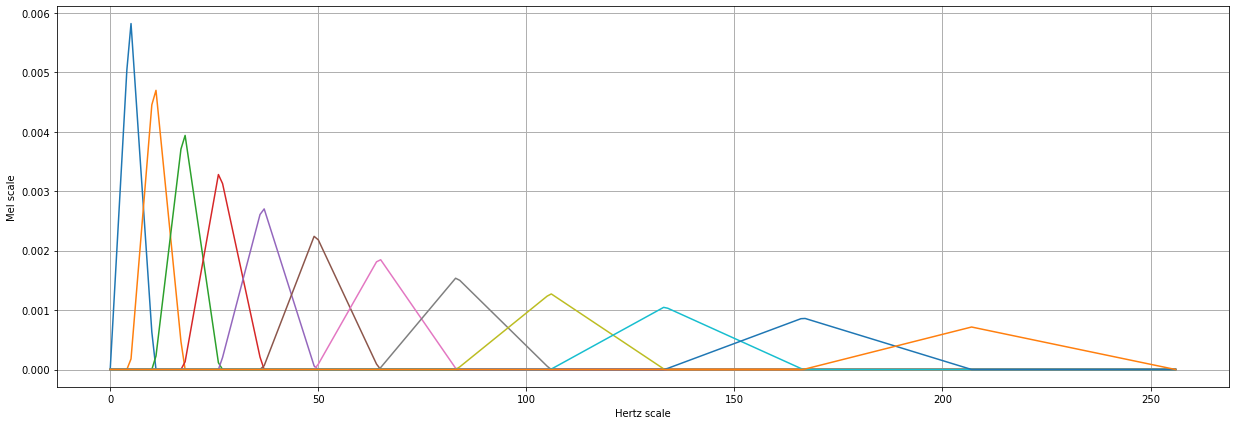

In [12]:
plt.figure(figsize=(21, 7))

filters = mel_filters(16000, 512, 12)

for y in filters:
    plt.plot(y)
plt.xlabel('Hertz scale')
plt.ylabel('Mel scale')
plt.grid(linestyle='-', linewidth=1)
plt.show()

In [13]:
def get_fbanks(wav: np.ndarray, sr: int, window_ms=25, step_mc=10, n_fbanks=40):
    # wav - input signal
    # sr - sample rate
    # window_ms - window length in milliseconds
    # step_ms - stft step in milliseconds
    # n_fbanks - number of filters
    # return fbank matrix [n_fbanks, time]

    n_fft = window_ms * sr // 1000
    hop_length = step_mc * sr // 1000
    win_length = window_ms * sr // 1000
    spec = np.abs(librosa.stft(wav, n_fft=n_fft, hop_length=hop_length, win_length=win_length)) ** 2
    mel_basis = mel_filters(sr, n_fft, n_fbanks)
    return np.dot(mel_basis, spec)

In [14]:
def test_fbank(wav, sr, window_ms=25, step_mc=10, n_fbanks=40):
    n_fft = window_ms * sr//1000
    hop_length = step_mc * sr//1000
    fbanks_lib = librosa.feature.melspectrogram(wav, sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_fbanks, htk=True)
    fbanks = get_fbanks(wav, sr, window_ms=window_ms, step_mc=step_mc, n_fbanks=n_fbanks)
    
    if fbanks_lib.shape != fbanks.shape:
        print("TEST FAILED")
        print(f"Shape {fbanks_lib.shape} != {fbanks.shape}")
    if not np.allclose(fbanks_lib, fbanks):
        print("TEST FAILED")
        print(f"Average diff is {np.mean(np.abs(fbanks_lib - fbanks))}")
        return -1
    print("TEST PASSED")
    return 0
    assert test_fbank(wav[:sr*1], sr) == 0, "1 sec wav test failed"
    assert test_fbank(wav, sr) == 0 , "All wav test failed"
    print("All ok!")
test_fbank(wav, sr, window_ms=25, step_mc=10, n_fbanks=40)

TEST PASSED


0

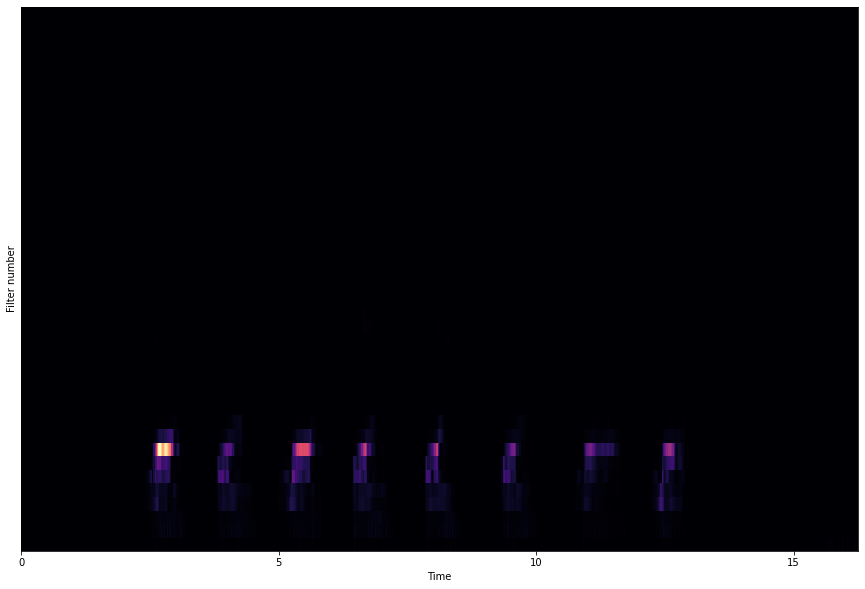

In [15]:
fbanks = get_fbanks(wav, sr)
plt.figure(figsize=(15,10))
librosa.display.specshow(fbanks, sr=sr, x_axis='time')
plt.ylabel("Filter number")
plt.show()

# Задание 3 (3 балла)
Реализовать вычисление [mfcc](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum)



In [16]:
def get_mfcc(wav: np.ndarray, sr: int, window_ms=25, step_mc=10, n_mfcc=13):
    # wav - input signal
    # sr - sample rate
    # window_ms - window length in milliseconds
    # step_ms - stft step in milliseconds
    # n_mfcc - number of filters
    # return mfcc matrix [n_mfcc, time]
    
    spec = librosa.core.power_to_db(get_fbanks(wav, sr, window_ms, step_mc)) 
    mfcc = scipy.fftpack.dct(spec, axis=0, type=2, norm="ortho")[:n_mfcc]
    return mfcc

In [17]:
def test_mfcc(wav, sr, window_ms=25, step_mc=10, n_mfcc=13):
    n_fft = window_ms * sr//1000
    hop_length = step_mc * sr//1000
    mfcc_lib = librosa.feature.mfcc(wav, sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc, n_mels=40, htk=True)
    mfcc = get_mfcc(wav, sr, window_ms=window_ms, step_mc=step_mc, n_mfcc=n_mfcc)
    
    if mfcc_lib.shape != mfcc.shape:
        print("TEST FAILED")
        print(f"Shape {mfcc_lib.shape} != {mfcc.shape}")
    if not np.allclose(mfcc_lib, mfcc, atol=1e-04):
        print("TEST FAILED")
        print(f"Average diff is {np.mean(np.abs(mfcc_lib - mfcc))}")
        return -1
    print("TEST PASSED")
    return 0
assert test_mfcc(wav[:sr*1], sr) == 0, "1 sec wav test failed"
assert test_mfcc(wav, sr) == 0 , "All wav test failed"
print("All ok!")

TEST PASSED
TEST PASSED
All ok!


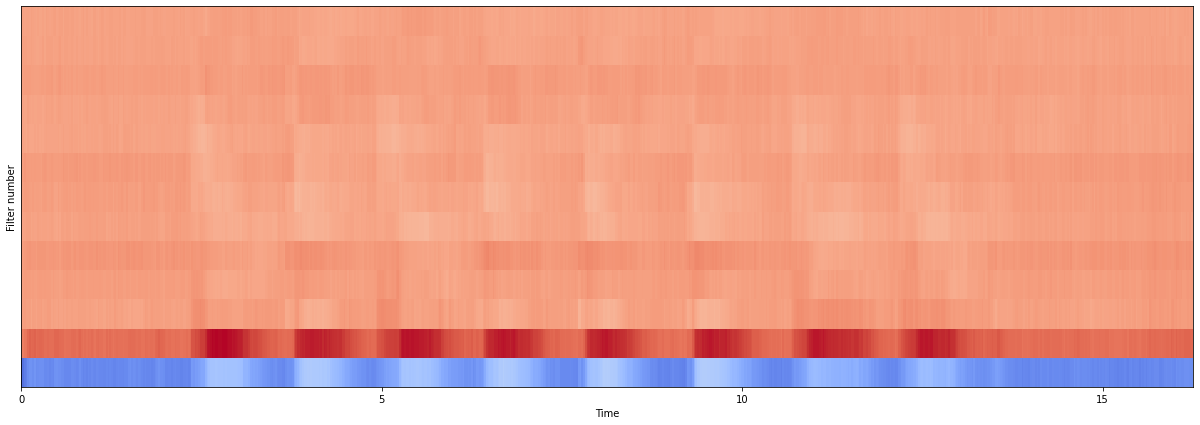

In [18]:
mfcc = get_mfcc(wav, sr)
plt.figure(figsize=(21, 7))
librosa.display.specshow(mfcc, sr=sr, x_axis='time')
plt.ylabel("Filter number")
plt.show()

# Классификация слов
Построим простую систему, классифицирующую слова yes/no.

Загрузим весь датасет

In [19]:
def load_yn_dataset(directory):
    X, labels = [], []
    for f in glob(directory +"/*.wav"):
        name = os.path.basename(f)[:-4]
        y = [int(l) for l in name.split("_")]
        x, sr = librosa.load(f)
        X.append(x)
        labels.append(y)
        
    return X, labels, sr

In [20]:
X, Y, sr = load_yn_dataset("resources/waves_yesno/")

Отделим 20% для теста

In [21]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y,test_size=0.2, random_state=1)

# Задание *4 (1 балл)
Voice Activity Detector (VAD) определяет, есть ли речь в текущем кадре или нет.
Реализуйте простой VAD.
Настройте VAD, чтобы хорошо определялись границы слов.

In [22]:
import torch
import torchaudio as ta
import torchaudio.functional as AF
import math
import logging

import matplotlib.pyplot as plt

/home/markh/anaconda3/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


Samplerate: 8000, Length of wav: 54080


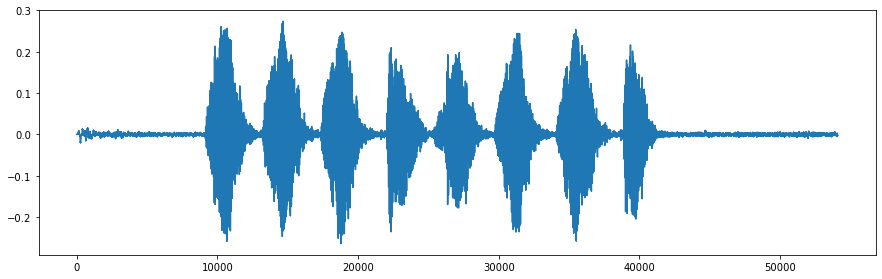

In [23]:
wav_file = 'resources/waves_yesno/0_0_0_1_0_0_0_1.wav'
wav, sr = ta.load(wav_file)
wav = wav[0]
print('Samplerate: {}, Length of wav: {}'.format(sr, len(wav)))
plt.figure(figsize=(15, 4.5))
plt.plot(wav)

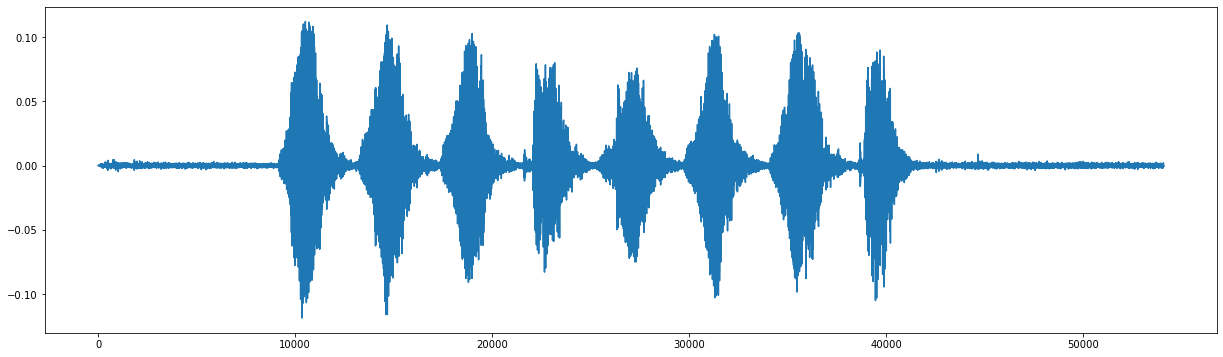

In [24]:
def preemphasis(signal, preemph=0.97):

    return np.concatenate((signal[0:1], signal[1:] - preemph * signal[:-1]))

wav = preemphasis(wav)

plt.figure(figsize=(21, 6))
plt.plot(wav);

In [25]:
def framesig(signal, framelen, framehop, winfunc=lambda x: np.ones((x,))):

    slen = len(signal)
    framelen = round(framelen)
    framehop = round(framehop)  
    if slen <= framelen:
        nframes = 1
    else:
        nframes = 1 + int(math.ceil((1.0 * slen - framelen) / framehop))

    padlen = int((nframes - 1) * framehop + framelen)

    zeros = np.zeros(padlen - slen, dtype=float, order='C')
    padsignal = np.concatenate((signal, zeros))

    indices = np.arange(0, framelen).view((1, -1)) \
              + np.arange(0, nframes * framehop, framehop).view((-1, 1))
    frames = padsignal[indices]
    win = winfunc(framelen).view((1, -1))
    return frames * win

frames = framesig(wav, 0.02*sr, 0.01*sr)
print('The length of a frame: {}, the length of a hop: {}'.format(round(winlen*sr), 
                                                                  round(hoplen*sr)))
plt.figure(figsize=(15, 4))
plt.imshow(frames.abs().t(), cmap='gray', aspect='auto', vmin=0, vmax=0.16)
plt.colorbar()

TypeError: Cannot interpret '1' as a data type

In [ ]:
# YOUR CODE HERE

# train_VA = # np.ndarray. 1 - Voice, 0 - silence
# test_VA = # np.ndarray. 1 - Voice, 0 - silence
        
#
    

In [ ]:
def test_VAD(VA, Y):
    def check_diff(diff, num_words):
        if diff.sum()!=0:
            print("VAD detected speech at the beginning (or end) of audio")
            return -1 
        if not (diff > 0).sum() == (diff > 0).sum() ==  num_words:
            print("Wrong number of words. Each audio contains 8 words")
            return -2
        return 0
    
    for i, (va, y) in enumerate(zip(VA, Y)):
        diff = va[1:]  - va[:-1]
        assert check_diff(diff, len(y)) == 0, f"Bad {i} example"

test_VAD(train_VA, Y_train)
test_VAD(test_VA, Y_test)

# Задание *5 (2 балла)
Обучите классификатор, определяющий, какое слово было сказано. Используйте VAD для разбиения входных файлов на отдельные слова. Классификацию можно сделать, например, с помощью SVM по усредненным признаки слов выделеных слов. Или любым другим удобным для вас способом. 